# Time Series

In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from pandas.plotting import lag_plot, autocorrelation_plot
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer

In [97]:
df = pd.read_csv("forecasting_example_dataset.csv")
df.columns = df.columns.str.lower()
df.head()

,item,date_feature,x1,x2,x3,x4,x5,target
0,A1,2017-04,10.542854,15.297332,13.278944,3.783778,36.591513,56.629772
1,A1,2017-05,10.035193,14.366332,15.836367,4.392242,34.376437,51.478831
2,A1,2017-06,10.731976,15.924658,13.162225,5.281605,39.144777,60.306802
3,A1,2017-07,10.482228,15.158375,14.210183,6.652001,52.283550,58.426564
4,A1,2017-08,10.165542,14.769391,13.782978,6.033006,60.222522,51.401700


# 1.0 Data Description

In [5]:
df.describe()

,x1,x2,x3,x4,x5,target
count,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000
mean,10.025068,15.622795,14.212460,5.017958,27.306604,52.465886
std,1.004246,2.703479,1.868821,1.014977,13.828185,17.496262
min,6.905391,8.820278,9.731894,1.823903,5.789739,12.989675
25%,9.428342,14.058165,12.877148,4.308520,17.234235,45.470873
50%,10.028568,15.787407,14.033296,4.932864,25.273372,55.785268
75%,10.688138,17.583727,15.519657,5.739751,36.597331,64.361044
max,12.870644,23.928815,19.673586,7.943156,73.007837,95.261499


In [6]:
df.isnull().sum()

item            0
date_feature    0
x1              0
x2              0
x3              0
x4              0
x5              0
target          0
dtype: int64

In [7]:
df.dtypes

item             object
date_feature     object
x1              float64
x2              float64
x3              float64
x4              float64
x5              float64
target          float64
dtype: object

# 2.0 Data Cleaning


# 3.0 Exploratory Data Analysis

In [20]:
print(df["date_feature"].min(), df["date_feature"].max())

2017-04 2024-12


## 3.2 Explore correlations between features and target

<Axes: >

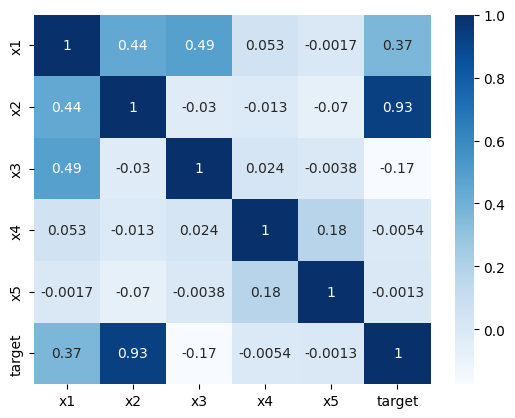

In [10]:
#Let's explore which variables correlate with the target and therefore, good predictors.
sns.heatmap(df.corr(), annot=True, cmap="Blues")

# 4.0 Test multiple models for monthly forecasting

In [98]:
df.dtypes

item             object
date_feature     object
x1              float64
x2              float64
x3              float64
x4              float64
x5              float64
target          float64
dtype: object

## 4.1 Target Shifting - The target will me moved two years ahead to match the required predictions

In [148]:
df = pd.read_csv("forecasting_example_dataset.csv")
df.columns = df.columns.str.lower()
df["date_feature"] = pd.to_datetime(df["date_feature"])
df["date_feature_2_years"] = df["date_feature"] + pd.DateOffset(years=2)
print(df.shape)
df = df.merge(df[["item","date_feature","target"]], left_on=["item","date_feature_2_years"], right_on=["item","date_feature"], how="left")
df = df.drop(columns=["date_feature_x","target_x","date_feature_y"]).rename(columns={"target_y":"target", "date_feature_2_years":"date_feature"})
print(df.shape)
df.head()

(465, 9)
(465, 8)


,item,x1,x2,x3,x4,x5,date_feature,target
0,A1,10.542854,15.297332,13.278944,3.783778,36.591513,2019-04-01,58.521531
1,A1,10.035193,14.366332,15.836367,4.392242,34.376437,2019-05-01,60.464787
2,A1,10.731976,15.924658,13.162225,5.281605,39.144777,2019-06-01,48.721589
3,A1,10.482228,15.158375,14.210183,6.652001,52.283550,2019-07-01,56.947818
4,A1,10.165542,14.769391,13.782978,6.033006,60.222522,2019-08-01,52.995916


In [186]:
# Split the data (up to 2024 for training)
train_df = df[df['date_feature'] <= "2022-01"]
test_df = df[df['date_feature'] > "2022-01"]



# You may want to do further splits if you need a validation set
X_train, y_train = train_df.drop(['target',"date_feature"], axis=1), train_df['target']
X_test, y_test = test_df.drop(['target',"date_feature"], axis=1), test_df['target']


# Since random forest regressor cannot handle string features (item), let's one-hot encode it
oe = OneHotEncoder(sparse_output=False)
oe.fit(X_train[["item"]])
X_train[oe.categories_[0]] = oe.transform(X_train[["item"]])
X_train = X_train.drop(columns="item") 

X_test[oe.categories_[0]] = oe.transform(X_test[["item"]])
X_test = X_test.drop(columns="item")
X_test.head()

,x1,x2,x3,x4,x5,A1,A2,A3,A4,A5
34,9.838128,12.883495,14.077351,3.934261,42.479478,1.0,0.0,0.0,0.0,0.0
35,8.851308,14.490927,12.237501,6.826223,34.197367,1.0,0.0,0.0,0.0,0.0
36,10.450369,14.701595,15.870499,5.342931,58.361343,1.0,0.0,0.0,0.0,0.0
37,9.102578,13.993765,12.839986,4.758570,47.142553,1.0,0.0,0.0,0.0,0.0
38,7.858528,13.788424,11.129445,5.047403,38.665153,1.0,0.0,0.0,0.0,0.0


In [187]:



# Defining the parameter grid for RandomForestRegressor
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Defining the parameter grid for XGBRegressor
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0]
}

# Defining the parameter grid for LGBMRegressor
lgbm_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.6, 0.8, 1.0]
}

# Define the scorer for RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Function to perform hyperparameter tuning
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmse_scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_score_

# Perform hyperparameter tuning for each model
# This operation can take some time, especially for larger datasets or more complex parameter grids
best_rf_model, best_rf_score = hyperparameter_tuning(RandomForestRegressor(random_state=42), rf_param_grid, X_train, y_train)
best_xgb_model, best_xgb_score = hyperparameter_tuning(XGBRegressor(random_state=42), xgb_param_grid, X_train, y_train)
best_lgbm_model, best_lgbm_score = hyperparameter_tuning(LGBMRegressor(random_state=42, force_col_wise=True), lgbm_param_grid, X_train, y_train)

print("best_random_forest_rmse_score", best_rf_score)
print("best_xgboost_rmse_score",best_xgb_score) 
print("best_lightgbm score",best_lgbm_score)  # Display the best RMSE scores for each model



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 10
[LightGBM] [Info] Start training from score 52.354619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [188]:
features = [ 'x1', 'x2', 'x3', 'x4', 'x5', 'A1', 'A2','A3', 'A4', 'A5']


final_test = df.copy()
final_test[oe.categories_[0]] = oe.transform(final_test[["item"]])
final_test = final_test.drop(columns="item")
final_test["predictions"] = best_xgb_model.predict(final_test[features])
final_test.head()

,x1,x2,x3,x4,x5,date_feature,target,A1,A2,A3,A4,A5,predictions
0,10.542854,15.297332,13.278944,3.783778,36.591513,2019-04-01,58.521531,1.0,0.0,0.0,0.0,0.0,58.523026
1,10.035193,14.366332,15.836367,4.392242,34.376437,2019-05-01,60.464787,1.0,0.0,0.0,0.0,0.0,60.464424
2,10.731976,15.924658,13.162225,5.281605,39.144777,2019-06-01,48.721589,1.0,0.0,0.0,0.0,0.0,48.707367
3,10.482228,15.158375,14.210183,6.652001,52.283550,2019-07-01,56.947818,1.0,0.0,0.0,0.0,0.0,56.941990
4,10.165542,14.769391,13.782978,6.033006,60.222522,2019-08-01,52.995916,1.0,0.0,0.0,0.0,0.0,52.999432


# 5.0 Final predictions for 2025 and 2026

In [180]:
final_test[(final_test["date_feature"]>="2025-01") & (final_test["date_feature"]<"2027-01")].set_index("date_feature")["predictions"].to_csv("predictions.csv")

# 6.0 Next steps ideas